In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import ElementsEnv
from scipy import signal

%erun Elements 5.12.0

os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/auxdir/'

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2

from nnpz.photometry import DirectoryFilterProvider, FnuuJyPrePostProcessor, PhotometryCalculator, PhotometryWithCorrectionsCalculator
from nnpz.reference_sample.ReferenceSample import ReferenceSample

In [2]:
import time
from datetime import timedelta

class Timing:
    def __init__(self):
        self.start = None
        self.end = None

    def __enter__(self):
        self.start = time.perf_counter()
            
    def __exit__(self, *args):
        self.end = time.perf_counter()
        print(f'{self.elapsed}')
    
    @property
    def elapsed(self):
        return timedelta(seconds=self.end - self.start)


In [3]:
ref_sample = ReferenceSample('/home/aalvarez/Work/Data/SC8/PHZPRD_D3_3_NOMINAL_20211006T095754-37VOZ8CE-20211006-095828-003/ProductionInputEcdmHandler/reference_sample_dir.dir/')

WARN    : Index for provider "pdz" does not follow the physical layout for file 1
2021-11-02T10:31:20CET nnpz.reference_sample.IndexProvider  WARN : Index for provider "pdz" does not follow the physical layout for file 1
WARN    : Index for provider "sed" does not follow the physical layout for file 1
2021-11-02T10:31:20CET nnpz.reference_sample.IndexProvider  WARN : Index for provider "sed" does not follow the physical layout for file 1
WARN    : Index for provider "sed" does not follow the physical layout for file 2
2021-11-02T10:31:20CET nnpz.reference_sample.IndexProvider  WARN : Index for provider "sed" does not follow the physical layout for file 2
WARN    : Index for provider "sed" does not follow the physical layout for file 3
2021-11-02T10:31:20CET nnpz.reference_sample.IndexProvider  WARN : Index for provider "sed" does not follow the physical layout for file 3
WARN    : Index for provider "sed" does not follow the physical layout for file 4
2021-11-02T10:31:20CET nnpz.refere

In [4]:
filters_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/SC8/PHZ_Calibration_28jan21/PhosphorosRootEcdmHandler/Phosphoros/AuxiliaryData/Filters/')

In [5]:
filter_map = {}
filter_names = filters_provider.getFilterNames()
for filter_name in filter_names:
    filter_map[filter_name] = filters_provider.getFilterTransmission(filter_name)

In [6]:
sid = np.random.choice(ref_sample.getIds())
sed = ref_sample.getSedData(sid)#9172773410680000)
assert(sed is not None)

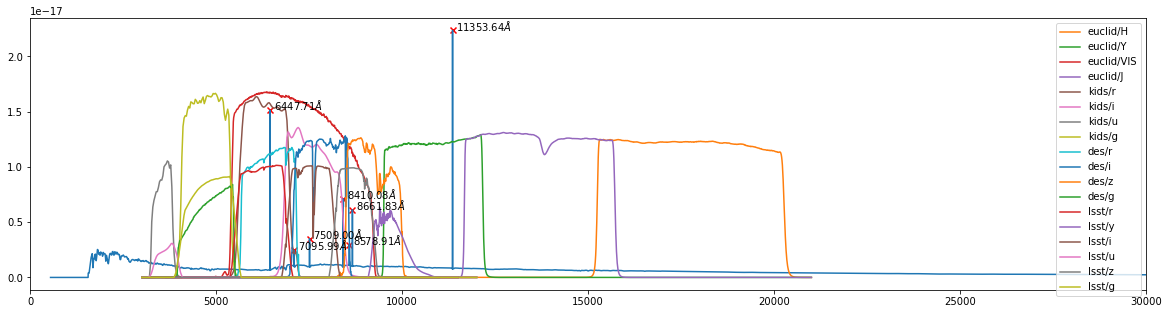

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(sed[:,0], sed[:,1])
msed = sed[:,1].max()
for fname, ftrans in filter_map.items():
    plt.plot(ftrans[:,0], ftrans[:,1]*msed, label=fname)
    
peaks, _ = signal.find_peaks(sed[:, 1], threshold=np.mean(sed[:,1]))
plt.scatter(sed[peaks,0], sed[peaks,1], marker='x', color='red')
for p in peaks:
    plt.text(sed[p,0]+100, sed[p,1], f'${sed[p,0]:.2f} \AA$')

plt.xlim(0, 30000)
plt.legend()
plt.savefig('/home/aalvarez/Downloads/peaks.png', bbox_inches='tight')
plt.show()

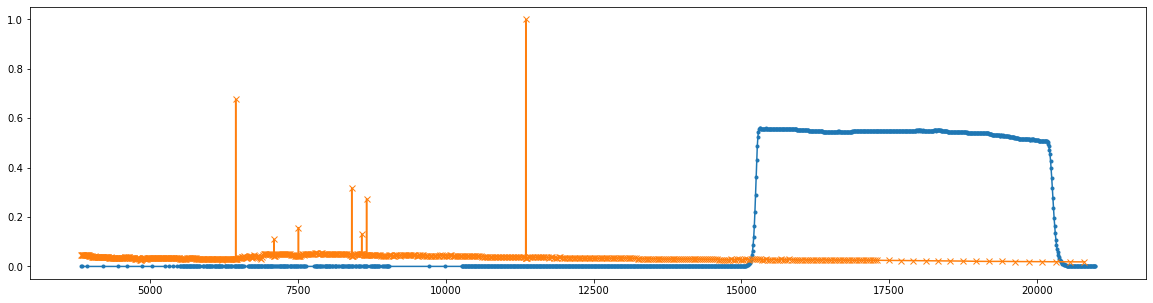

In [8]:
plt.figure(figsize=(20, 5))
f = filter_map['euclid/H']
fmask = f[:,1] > 0
plt.plot(f[fmask,0], f[fmask,1], marker='.')
smask = (sed[:,0]>=f[fmask,0].min()) & (sed[:,0]<=f[fmask,0].max())
plt.plot(sed[smask,0], (sed[smask,1]/sed[smask,1].max()), marker='x')

In [10]:
shifts = np.concatenate([np.arange(-100, 0), np.arange(1, 101)])
extra_shifts = np.concatenate([np.arange(-200, -100), np.arange(100, 201)])

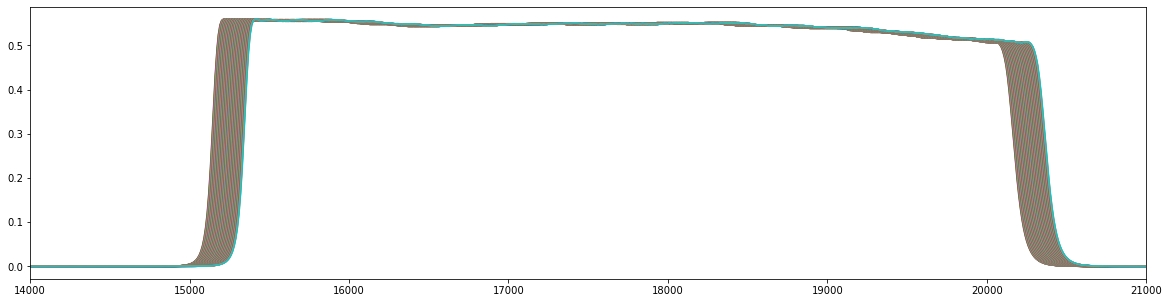

In [11]:
plt.figure(figsize=(20,5))

for s in shifts:
    grid = np.unique(np.concatenate([sed[:,0], f[:,0]+s, f[-1:,0]+s+1]))
    finterp = np.interp(grid, f[:,0]+s, f[:,1], left=0, right=0)
    sinterp = np.interp(grid, sed[:,0], sed[:,1], left=0, right=0)
    plt.plot(grid, finterp)
    plt.xlim(14000, 21000)

In [12]:
prepost = FnuuJyPrePostProcessor(filter_map)

In [13]:
calculator = PhotometryCalculator(filter_map, prepost, shifts)

In [14]:
corrector = PhotometryWithCorrectionsCalculator(filter_map, prepost, 0.3, shifts)

In [45]:
def plot_interp(raw, photo, corr, axes=None, label=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(ncols=3, nrows=len(filter_map)//3, figsize=(20, 20))

    for i, ax in enumerate(axes.ravel()):
        fname = filter_names[i]

        ax.set_title(fname)
        ax.scatter(shifts, raw[fname], marker='.', color='black' if not label else None, label='Raw'if not label else label)
        a, b = corr[filter_names[i]]
        ax.plot(shifts, photo[fname][0]*(a * shifts**2 + b * shifts + 1), color='green' if not label else None, label='Fit' if not label else f'Fit {label}', **kwargs)

        if i == 0:
            ax.legend()

# Use filter grid

In [16]:
def filter_grid(trans, sed):
    return trans[:, 0]

In [17]:
with Timing():
    photo, raw = calculator.compute(sed, filter_grid)
    _, _, corr = corrector.compute(sed, filter_grid)

0:00:00.664057


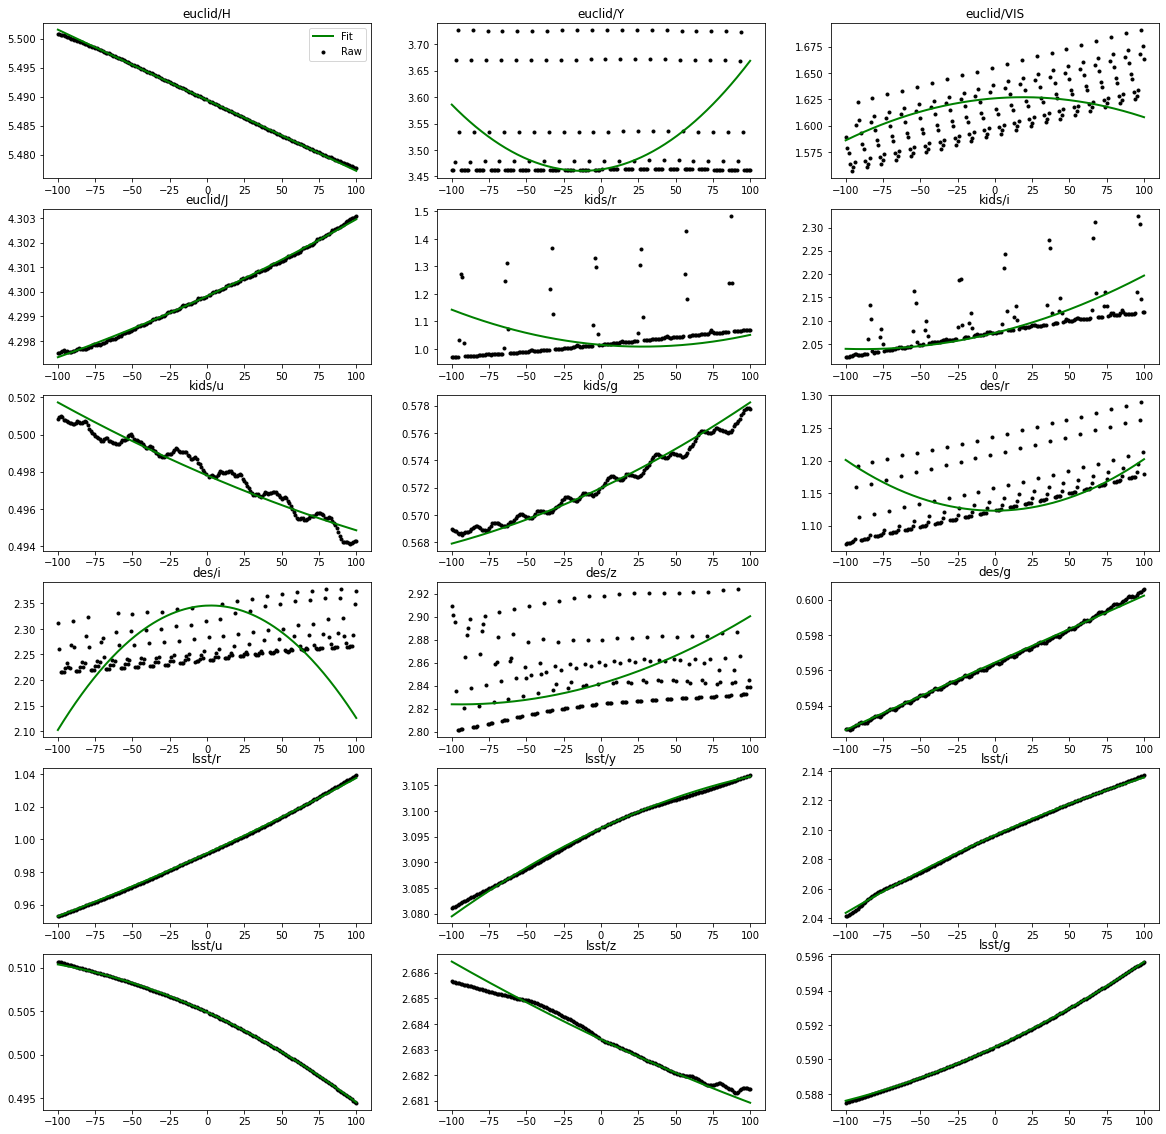

In [18]:
plot_interp(raw, photo, corr)

# Use SED grid

In [19]:
def sed_grid(trans, sed):
    return sed[:,0]

In [20]:
with Timing():
    photo, raw = calculator.compute(sed, sed_grid)
    _, _, corr = corrector.compute(sed, sed_grid)

0:00:00.550365


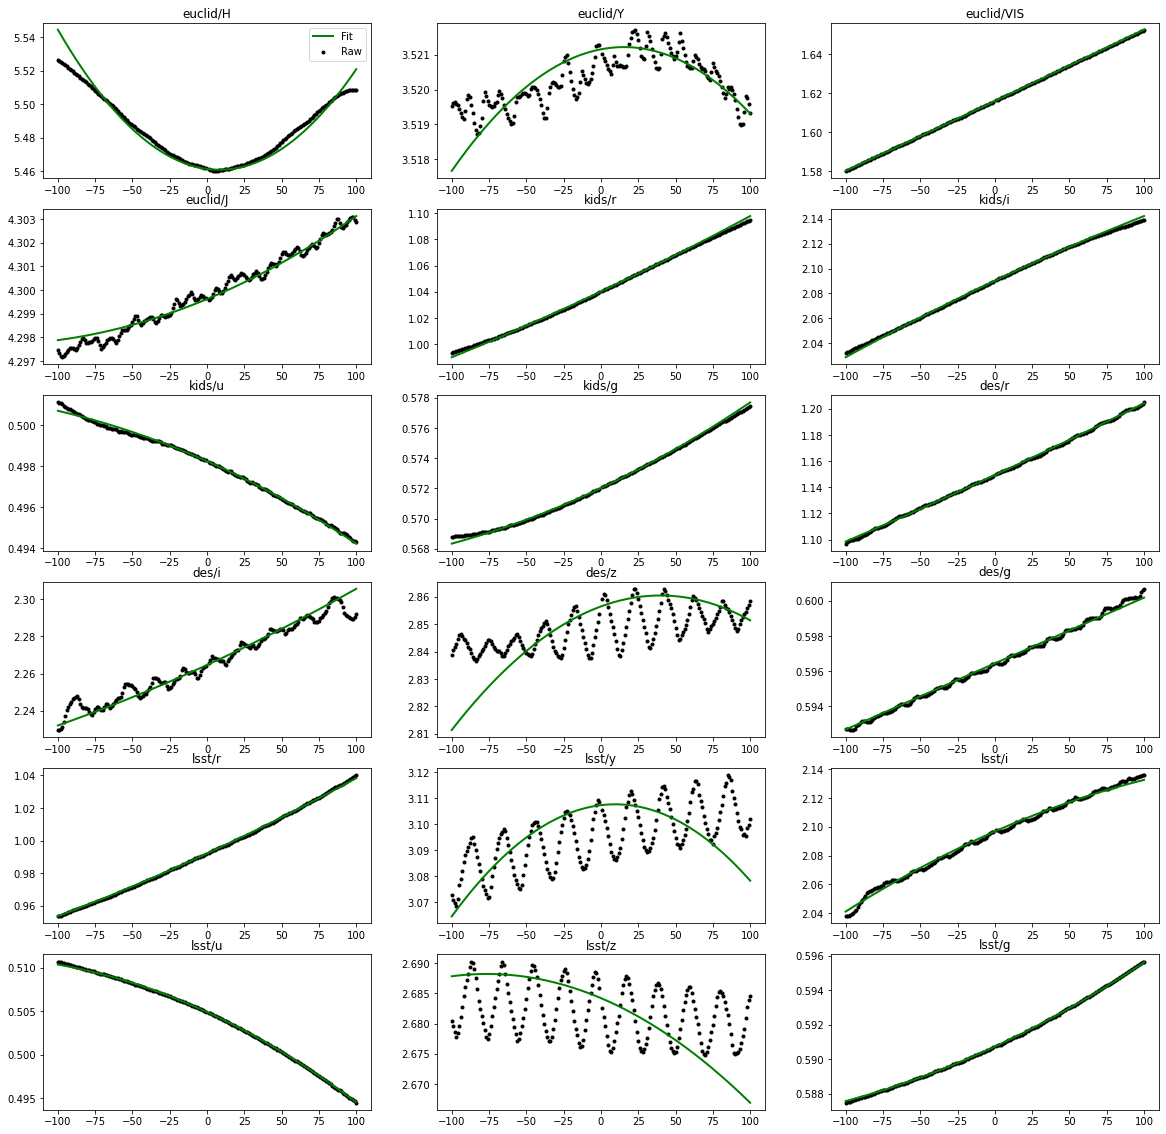

In [21]:
plot_interp(raw, photo, corr)

# Merge both

In [22]:
def comb_grid(trans, sed):
    return np.unique(np.concatenate([trans[:,0], sed[:,0]]))

In [23]:
with Timing():
    uphoto, uraw = calculator.compute(sed, comb_grid)
    _, _, ucorr = corrector.compute(sed, comb_grid)

0:00:01.765870


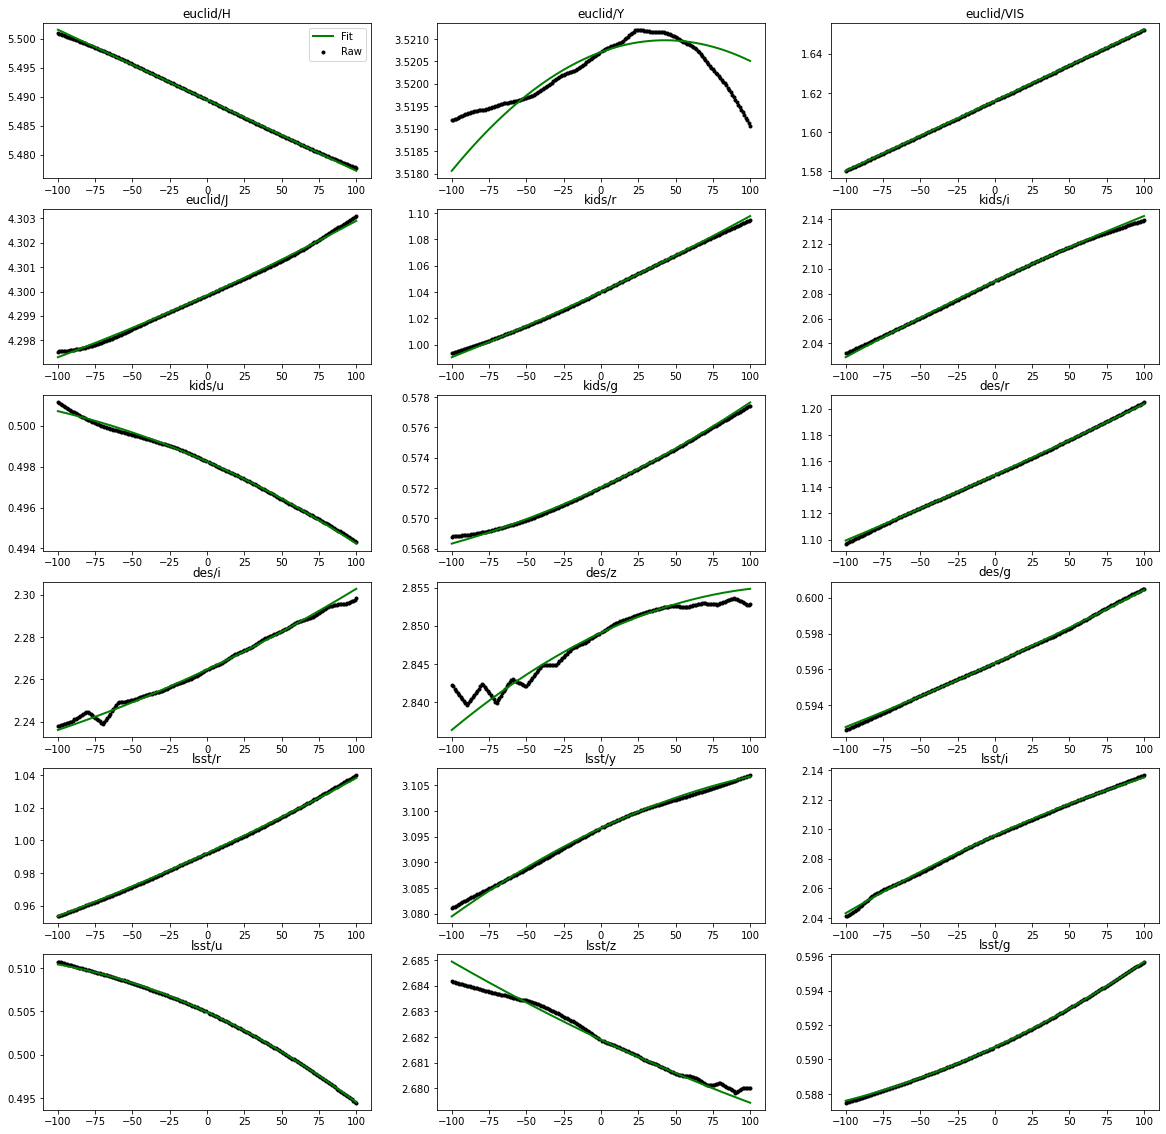

In [24]:
plot_interp(uraw, uphoto, ucorr)

# Smallest dx

In [25]:
def smallest_dx(trans, sed):
    start, end = trans[:,0].min(), trans[:,0].max()
    step = np.diff(sed[:,0]).min(initial=np.diff(trans[:,0]).min())
    return np.arange(start+np.min(shifts)-1, end+np.max(shifts)+1, step=step)

In [26]:
with Timing():
    mphoto, mraw = calculator.compute(sed, smallest_dx)
    _, _, mcorr = corrector.compute(sed, smallest_dx)

0:00:02.255710


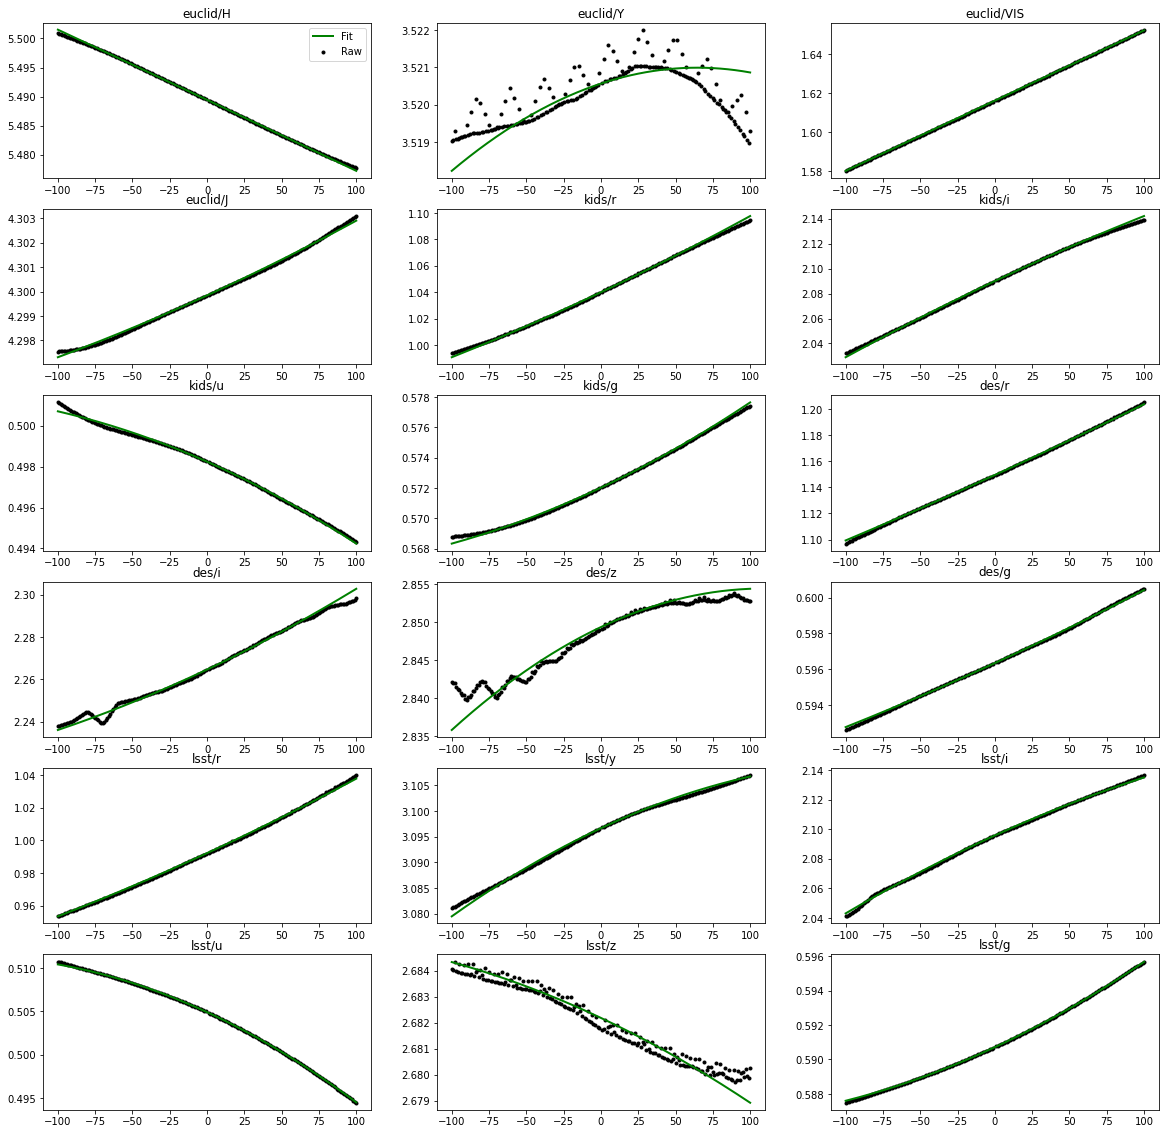

In [27]:
plot_interp(mraw, mphoto, mcorr)

# Fixed grid

In [28]:
def fixed(trans, sed):    
    start, end = trans[:,0].min(), trans[:,0].max()
    return np.arange(start, end, step=1)

In [29]:
with Timing():
    fphoto, fraw = calculator.compute(sed, fixed)
    _, _, fcorr = corrector.compute(sed, fixed)

0:00:01.375436


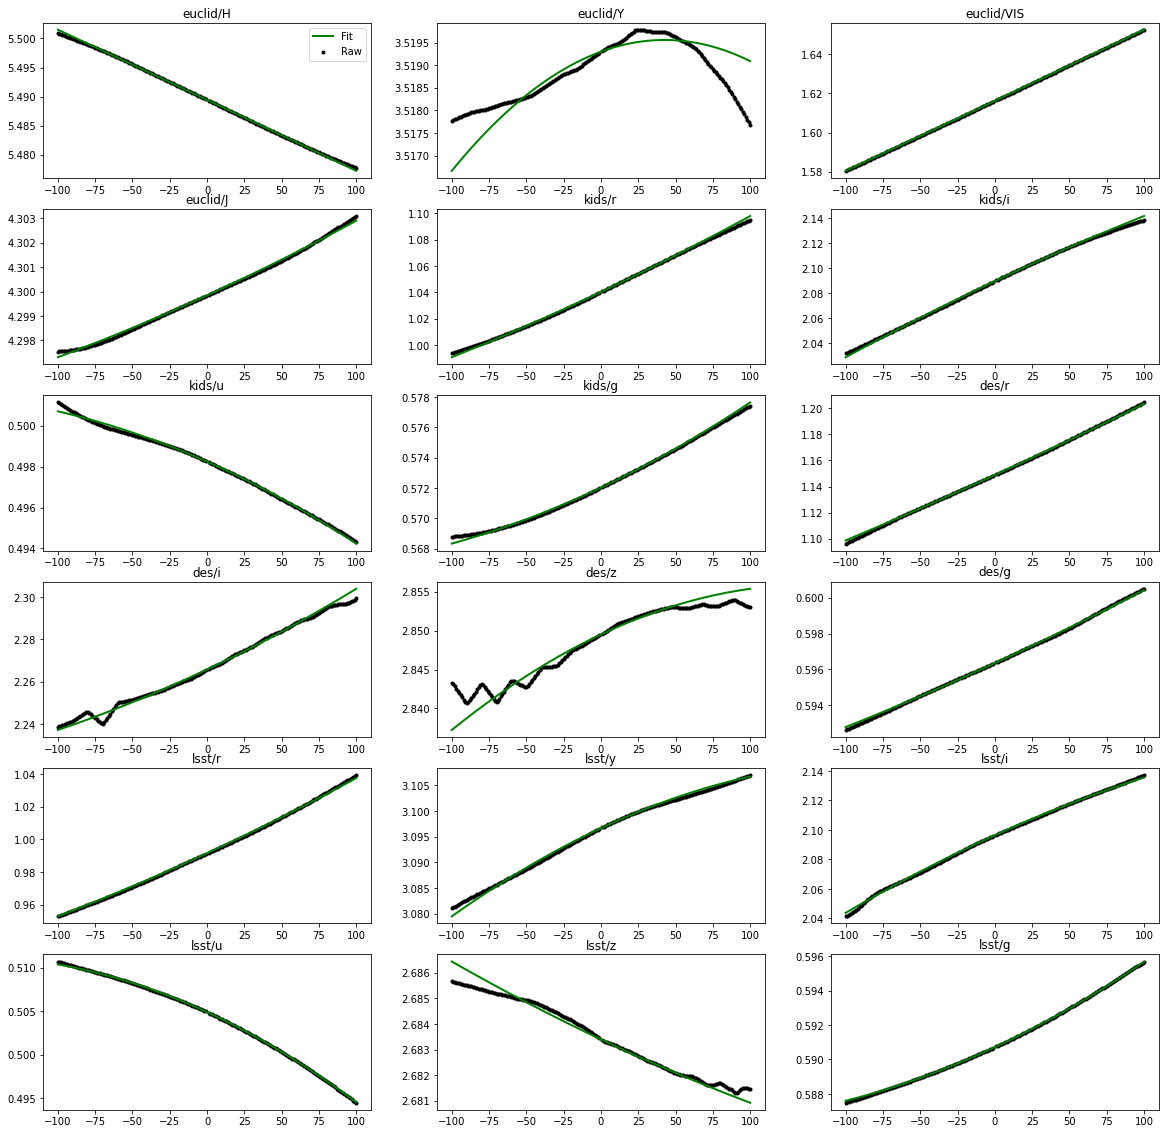

In [30]:
plot_interp(fraw, fphoto, fcorr)

# Fixed grid with deltas

In [31]:
def fixed_with_deltas(trans, sed):
    tmask = trans[:,1] > 0
    start, end = trans[tmask,0].min(), trans[tmask,0].max()
    grid = np.arange(start, end+1, step=1)
    peaks, _ = signal.find_peaks(sed[:, 1], threshold=np.mean(sed[:,1]))
    pidx = np.concatenate([peaks, peaks-1, peaks+1])
    return np.unique(np.concatenate([grid, sed[pidx, 0]]))

In [32]:
with Timing():
    photo, raw = calculator.compute(sed, fixed_with_deltas)
    _, _, corr = corrector.compute(sed, fixed_with_deltas)

0:00:03.145550


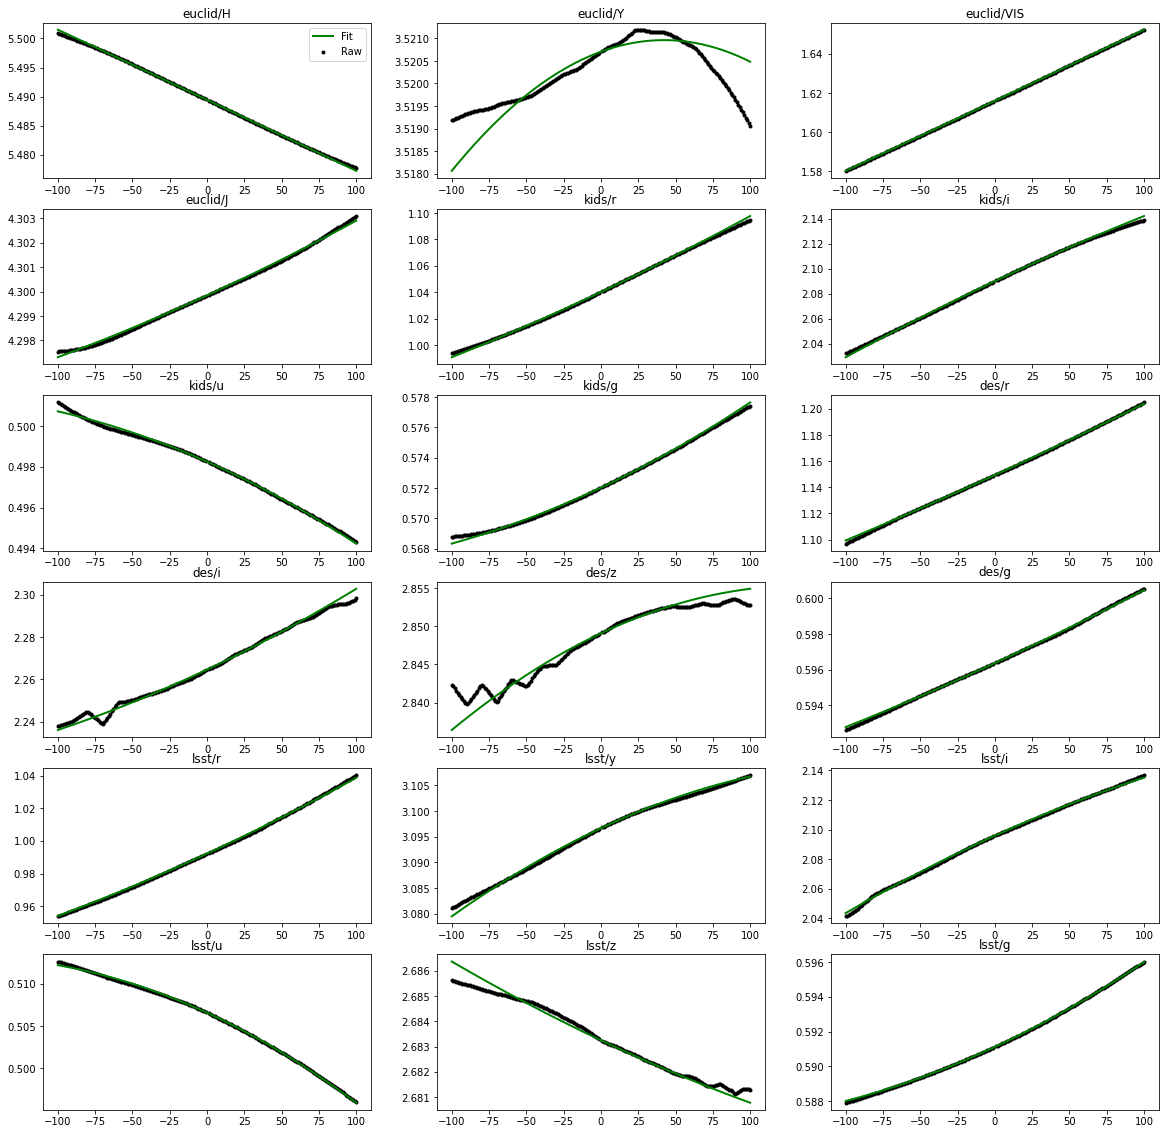

In [33]:
plot_interp(raw, photo, corr)

# Plot together

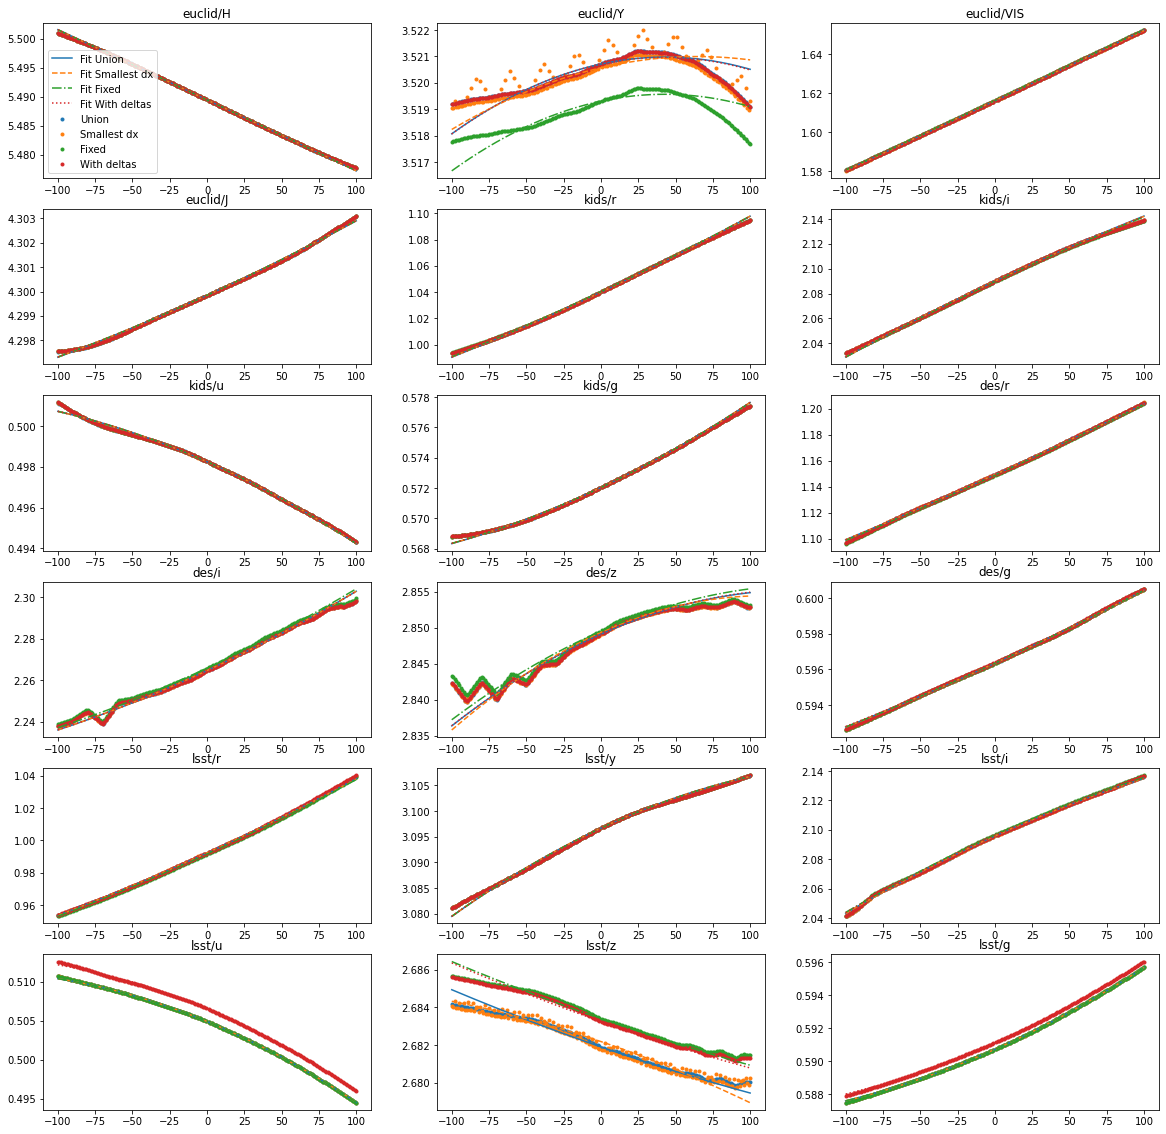

In [48]:
fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(20, 20))

plot_interp(uraw, uphoto, ucorr, axes=axes, label='Union', linestyle='-')
plot_interp(mraw, mphoto, mcorr, axes=axes, label='Smallest dx', linestyle='--')
plot_interp(fraw, fphoto, fcorr, axes=axes, label='Fixed', linestyle='-.')
plot_interp(raw, photo, corr, axes=axes, label='With deltas', linestyle=':')

fig.savefig('/home/aalvarez/Downloads/approaches.png', bbox_inches='tight')

# Cross check default impl

In [35]:
with Timing():
    dphoto, draw = calculator.compute(sed, None)
    _, _, dcorr = corrector.compute(sed, None)

0:00:01.735066


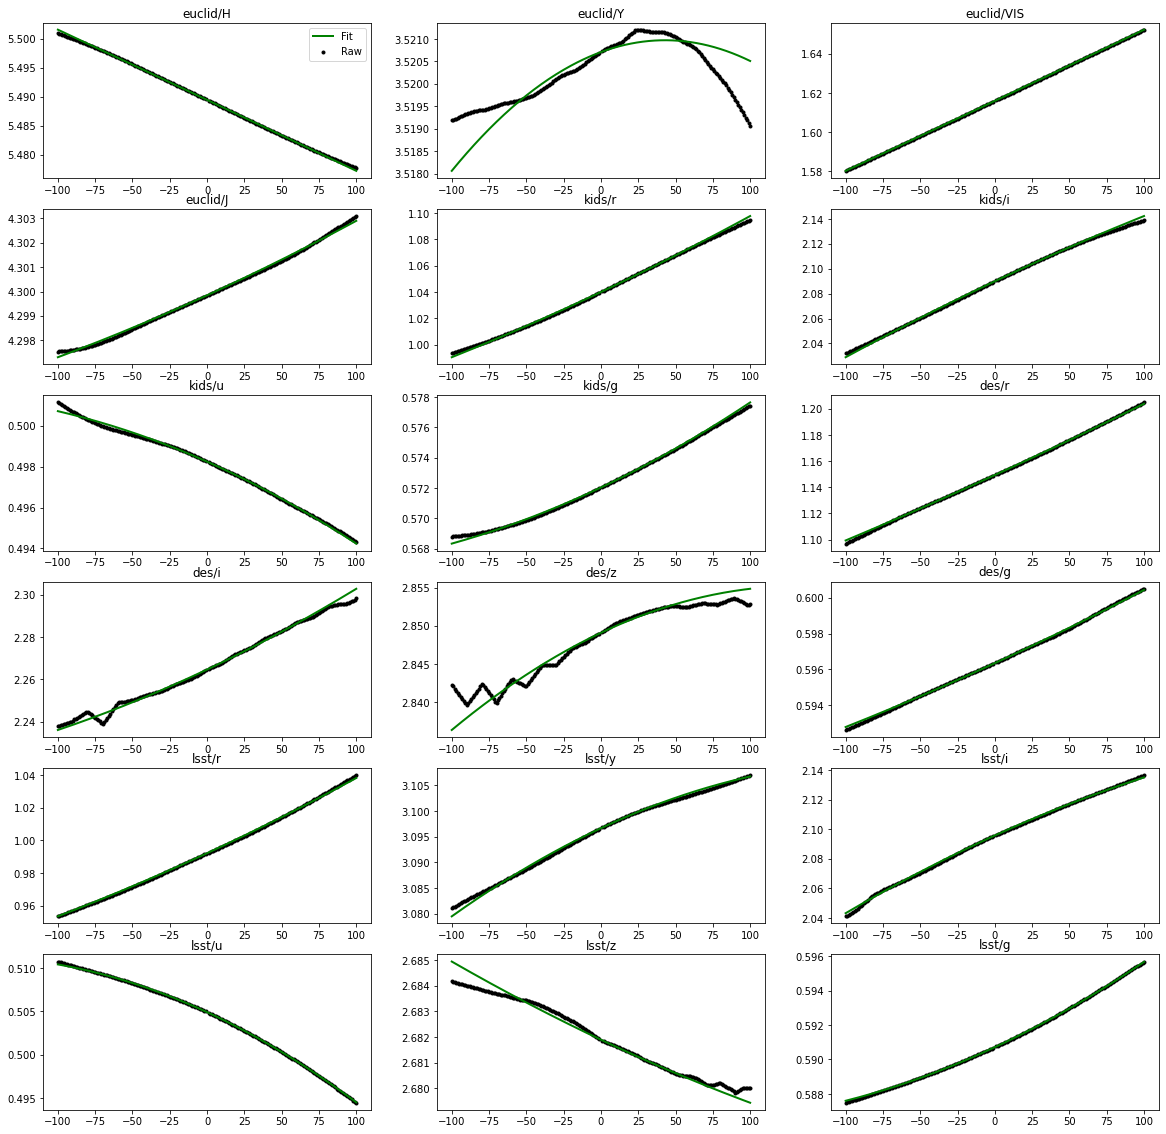

In [36]:
plot_interp(draw, dphoto, dcorr)